# Korean Word2Vec

> ## 네이버 영화 리뷰 데이터

In [2]:
import warnings
warnings.filterwarnings('ignore')

# I. Install & Import Packages

* Install KoNLPy

In [3]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 41.0 MB/s eta 0:00:00


* Import Packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth = 200)

import tensorflow

# II. Data Preprocessing

> ## 1) ratings_train.txt Download

In [5]:
tr_url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
path_to_train_file = tensorflow.keras.utils.get_file('train.txt', tr_url)

14628807/14628807 [==============================] - 0s 0us/step


In [6]:
path_to_train_file

'/root/.keras/datasets/train.txt'

> ## 2) 데이터 읽어오기

* Label : '1'(긍정), '0'(부정)

In [7]:
train_data = pd.read_table(path_to_train_file)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [9]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


* 네이버 영화 리뷰 DataFrame 정보

> ## 3) 데이터 정제(Cleaning)

* NULL값 존재 확인

In [17]:
train_data[(train_data['document'].isnull())]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


* NULL값 행 제거 후 확인

In [18]:
train_data = train_data.dropna(how = 'any')

In [19]:
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


* NULL값 제거 후 DataFrame

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


> ## 4) Okt( ) Tokenization

* 약 12분

In [21]:
%%time

from konlpy.tag import Okt

okt = Okt()
tokenized_data = []

for sentence in train_data['document']:
    temp_X = okt.morphs(sentence)
    tokenized_data.append(temp_X)

CPU times: user 3min 29s, sys: 933 ms, total: 3min 30s
Wall time: 3min 29s


* Tokenization 결과 확인

In [22]:
len(tokenized_data)

149995

In [23]:
tokenized_data[:4]

[['아', '더빙', '..', '진짜', '짜증나네요', '목소리'],
 ['흠',
  '...',
  '포스터',
  '보고',
  '초딩',
  '영화',
  '줄',
  '....',
  '오버',
  '연기',
  '조차',
  '가볍지',
  '않구나'],
 ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천', '한', '다'],
 ['교도소', '이야기', '구먼', '..', '솔직히', '재미', '는', '없다', '..', '평점', '조정']]

# III. 리뷰 데이터 분포 시각화

> ## 1) 리뷰 길이 확인

In [24]:
print('리뷰의 최대 길이:', max(len(n) for n in tokenized_data))
print('리뷰의 평균 길이:', sum(map(len, tokenized_data))/len(tokenized_data))

리뷰의 최대 길이: 95
리뷰의 평균 길이: 14.374899163305443


> ## 2) 리뷰 길이 시각화

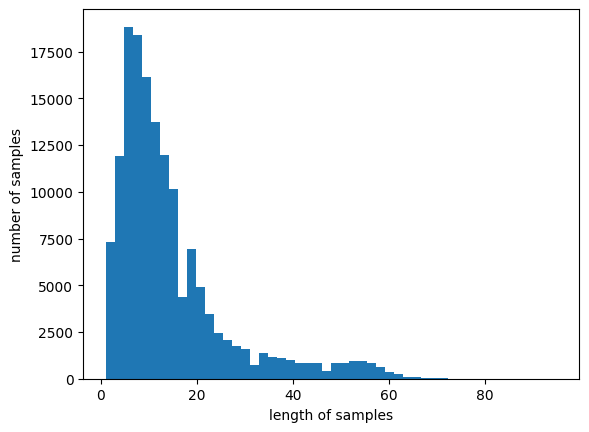

In [25]:
plt.hist([len(s) for s in tokenized_data], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# IV. Word2Vec 수행

* https://radimrehurek.com/gensim

> ## 1) 임베딩 학습

* sentences: 임베딩시킬 문장
* vector_size: 임베딩 된 벡터 차원(크기)
* window: 문맥 윈도우 크기(의미파악에 고려할 주변단어 개수)
* min_count: 단어 최소 빈도 수 제한(빈도가 낮은 단어 학습 안함)
* sg: 0(CBOW), 1(Skip-gram)

In [26]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data,
                 vector_size = 256, #보통 100~300
                 window = 3,
                 min_count = 5,
                 sg = 1)

> ## 2) 학습된 임베딩 매트릭스 크기 확인

In [27]:
model.wv.vectors.shape

(22828, 256)

# V. 임베딩 결과 테스트

In [41]:
model.wv.most_similar(positive = ['타이타닉'], 
                      topn = 5)

[('컴퓨터그래픽', 0.9110733270645142),
 ('물량', 0.8964664936065674),
 ('알린', 0.8912248611450195),
 ('놈놈놈', 0.8881630301475525),
 ('홍자매', 0.8876987099647522)]

In [39]:
model.wv.most_similar(positive = ['느와르'], 
                      topn = 5)

[('블랙코미디', 0.8655874133110046),
 ('SF', 0.8486344814300537),
 ('정통', 0.8438126444816589),
 ('물의', 0.8434446454048157),
 ('호러', 0.843217134475708)]

In [38]:
model.wv.most_similar(positive = ['강아지', '가족' , '액션'],
                      negative = ['멜로'], 
                      topn = 5)

[('자녀', 0.723659336566925),
 ('애인', 0.7048346400260925),
 ('절친', 0.6985787153244019),
 ('어르신', 0.696077287197113),
 ('직장인', 0.6939414143562317)]

# 
# 
# 
# The End
# 
# 
# 